# [CS376] Homework 2. PCA

- TA : Donghoon Ham (dhham@ai.kaist.ac.kr), Jaehong Yoon (jaehong.yoon93@gmail.com)
- Due Date : 15th Dec, 23:59 (**Any late submissions will not be accepted.**)
- Office Hour : E3-1 2443, Tues 18:30~21:30 
- Skeleton codes for this homework are based on tutorial code for textbook written by Marc Deisenroth. 
- If you're not familar with Google colab or Jupyter notebook, contact TAs in e-mail or come TA office hour on tuesday to get our help.




## README

This notebook file is *incomplete* at the first time, so you should implement some code cells for this homework.

In addition, you should write answers for given questions.

In HW2, you should submit following file:
- `hw2.ipynb`: a **completed** version of this IPython notebook. 
  - You should **implement total 5 python code cells (which are marked as TODO)** and **exercise problem** for given questions. 
  - Every code cell should be working and leave outputs when you submit HW.
  - To avoid cheating, **comment out each piece of code in detail**.
  - **Do NOT clear** your outputs (ex. plots, outputs, etc.).  

After finishing the homework, please submit this file to **Homework 2 section in KLMS**.



### Instructions
- First of all, you should copy the original Colab notebook into your Google drive.
  - Sign in Google.
  - Click `File` in the left top on menu and select `Save a copy in Drive..`.
- Then you can edit your copied notebook in Google Colab!
  - Fill in the `TODO` marked part to run appropriately. 
  - Each code cell will be executed when you click the play button left side of the cell (or press `Ctrl+Enter`).
- Download your copied notebook file (`.ipynb` file) to your local and rename it as `hw2.ipynb`.
- Upload the file (`hw2.ipynb`) to KLMS Homework 1 section.

##<font color=red>**[IMPORTANT]**</font>

**Please submit the notebook file (without compressing) with the name like below:**

**HW2_StudentID.ipynb**

**ex) HW2_20191234.ipynb**

<font color=red>**If you do not follow this format, you may be penalized.**</font>

### Q&A Policies
- If you think your question is important for every student, make your question about HW as a comment on the code cell block in [the original notebook](https://colab.research.google.com/drive/1Ye7fnZ3PZl2REidUhWT0aNWGDYzEPVJb), not your copy.
- If you want to ask some questions about your code, contact TAs in e-mail or come TA office hour.



---




## 0. Prerequisites

You can use following packages in this HW:

1. Write code that implements PCA.
2. Write code that implements PCA for high-dimensional datasets
3. Visuallize PCA results.

Let's first import the packages we need for this HW

**You can use Numpy library for implement these questions**

In [0]:
# PACKAGE: DO NOT EDIT THIS CELL
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact
from sklearn.datasets import fetch_mldata

In [0]:
# PACKAGE: DO NOT EDIT THIS CELL
from sklearn.datasets import fetch_openml
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [0]:
%matplotlib inline

Now, let's plot a digit from the dataset:

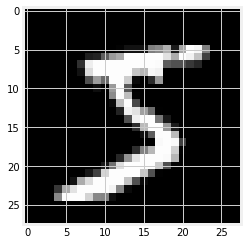

In [53]:
plt.figure(figsize=(4,4))
plt.imshow(images[0].reshape(28,28), cmap='gray');

Before we implement PCA, we will need to do some data preprocessing. In this assessment, some of them 
will be implemented by you, others we will take care of. However, when you are working on real world problems, you will need to do all these steps by yourself.

The preprocessing steps we will do are
1. Convert unsigned interger 8 (uint8) encoding of pixels to a floating point number between 0 and 1.
2. Subtract from each image the mean $\boldsymbol \mu$.
3. Scale each dimension of each image by $\frac{1}{\sigma}$ where $\sigma$ is the stardard deviation.

The steps above ensure that our images will have zero mean and one variance. These preprocessing
steps are also known as [Data Normalization or Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).

## 1. PCA

Now we will implement PCA. Before we do that, let's pause for a moment and
think about the steps for performing PCA. Assume that we are performing PCA on
some dataset $\boldsymbol X$ for $M$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Data normalization (`normalize`).
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $S$.
   Sort by the largest eigenvalues and the corresponding eigenvectors (`eig`).

After these steps, we can then compute the projection and reconstruction of the data onto the spaced spanned by the top $n$ eigenvectors.

In [0]:
## TODO 1~4: EDIT THESE FUNCTIONS

def normalize(X):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): tuple of ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    std_values = np.std(X, axis=0) # dtype=np.float64)
    modified_std_values = std_values
    for i, v in enumerate(std_values):
      if v == 0:
        modified_std_values[i] = 1
    mean_values = np.mean(X, axis=0)# dtype=np.float64)
    Xbar = np.divide((X - mean_values), modified_std_values)#, dtype=np.float64)

    return (Xbar, mean_values, std_values) # <-- EDIT THIS to return Xbar, mean, std


    
def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors 
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix
    
    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs should be sorted in descending
        order of the eigen values
    """

    w, v = np.linalg.eig(S)
    v = v.T
    # to sort
    eigenvec_saves = {}
    for i, eigenvec in enumerate(v):
        eigenvec_saves[i] = eigenvec
    eigenval_saves = [(x[0], x[1]) for x in enumerate(w)]
    eigenval_saves = sorted(eigenval_saves, key=lambda x:x[1])
    eigenval_saves.reverse()
    sorted_eigenval = np.array(list(map(lambda x: x[1], eigenval_saves)))
    sorted_eigenvec = []

    for info in eigenval_saves:
      sorted_eigenvec.append(eigenvec_saves[info[0]])
    sorted_eigenvec = np.array(sorted_eigenvec)


    return (sorted_eigenval, sorted_eigenvec.T) # <-- EDIT THIS to return the eigenvalues and corresponding eigenvectors

def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    btb = np.dot(B.T, B)
    n, _ = np.shape(btb)
    proj_matrix = np.dot(B, np.dot(np.linalg.inv(btb), np.transpose(B)))
    return proj_matrix # <-- EDIT THIS to compute the projection matrix

def PCA(X, num_components):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: ndarray of the reconstruction
        of X from the first `num_components` principal components.
    """
    size_n, _ = np.shape(X)

    S = np.divide(np.dot(X.T, X), size_n)
    _, eigenvecs = eig(S)
    eigenvecs = eigenvecs[:,:num_components]

    return np.dot(X, projection_matrix(eigenvecs).T)
    # your solution should take advantage of the functions you have implemented above.


In [0]:
## Some preprocessing of the data
NUM_DATAPOINTS = 1000
X = (images.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.
Xbar, mu, std = normalize(X)

In [56]:
for num_component in range(1, 20):
    from sklearn.decomposition import PCA as SKPCA
    # We can compute a standard solution given by scikit-learn's implementation of PCA
    pca = SKPCA(n_components=num_component, svd_solver='full')
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))
    reconst = PCA(Xbar, num_component)
    np.testing.assert_almost_equal(reconst, sklearn_reconst) # <-- If your implementaion is wrong, this line gives you error message. Fix your above implementation
    print(np.square(reconst - sklearn_reconst).sum()) # <-- If this value is very small (1e-25~), then you maybe correct

(3.4482231334582304e-25+0j)
(6.643413859269463e-25+0j)
(8.903671242312248e-25+0j)
(2.2041456644237303e-24+0j)
(1.20946788958604e-24+0j)
(1.6362811602087048e-24+0j)
(3.2760487592113962e-24+0j)
(1.8858367572728483e-24+0j)
(2.283156041960972e-23+0j)
(3.0175695312611966e-23+0j)
(8.547307966772752e-22+0j)
(5.610731288834671e-23+0j)
(5.668341760071311e-23+0j)
(6.898428172363149e-24+0j)
(6.093371367235622e-24+0j)
(8.65989209796294e-23+0j)
(3.275281178186907e-23+0j)
(9.966875062948206e-24+0j)
(7.376272224788972e-24+0j)


The greater number of principal components we use, the smaller will our reconstruction
error be. Now, let's answer the following question: 


> How many principal components do we need
> in order to reach a Mean Squared Error (MSE) of less than $100$ for our dataset?



We have provided a function in the next cell that computes the mean squared error (MSE), which will be useful for answering the question above.

In [0]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [0]:
loss = []
reconstructions = []
# iterate over different numbers of principal components, and compute the MSE
for num_component in range(1, 100):
    reconst = PCA(Xbar, num_component)
    error = mse(reconst, Xbar)
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
loss = np.asarray(loss)

In [59]:
import pandas as pd
# create a table showing the number of principal components and MSE
pd.DataFrame(loss).head()

,0,1
0,1.000000+0.000000j,569.447737+0.000000j
1,2.000000+0.000000j,536.059608+0.000000j
2,3.000000+0.000000j,508.250286+0.000000j
3,4.000000+0.000000j,487.018907+0.000000j
4,5.000000+0.000000j,467.571610+0.000000j


We can also put these numbers into perspective by plotting them.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


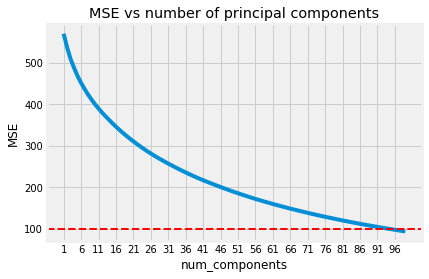

In [60]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(100, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

But _numbers dont't tell us everything_! Just what does it mean _qualitatively_ for the loss to decrease from around
$450.0$ to less than $100.0$?

Let's find out! In the next cell, we draw the the leftmost image is the original dight. Then we show the reconstruction of the image on the right, in descending number of principal components used.

In [61]:
@interact(image_idx=(0, 1000))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    # concatenate the actual and reconstructed images as large image before plotting it
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.real(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)])),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

interactive(children=(IntSlider(value=500, description='image_idx', max=1000), Output()), _dom_classes=('widge…

We can also browse throught the reconstructions for other digits. Once again, `interact` becomes handy for visualing the reconstruction.

In [62]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    """Show the i th digit and its reconstruction"""
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :] * std + mu).reshape(28, 28)
    plt.imshow(np.real(np.hstack([actual_sample, reconst_sample])), cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=1, description='i', max=10), Output()), _dom_classes=('widget-interact',…

## 2. PCA for high-dimensional datasets

Sometimes, the dimensionality of our dataset may be larger than the number of samples we
have. Then it might be inefficient to perform PCA with our implementation above. Instead,
we can implement PCA in a more efficient manner, which we call "PCA for high dimensional data" (PCA_high_dim).

Below are the steps for performing PCA for high dimensional dataset
1. Compute the matrix $\boldsymbol X\boldsymbol X^T$ (a $N$ by $N$ matrix with $N \ll D$)
2. Compute eigenvalues $\lambda$s and eigenvectors $V$ for $\boldsymbol X\boldsymbol X^T$
3. Compute the eigenvectors for the original covariance matrix as $\boldsymbol X^T\boldsymbol V$. Choose the eigenvectors associated with the M largest eigenvalues to be the basis of the principal subspace $U$.
4. Compute the orthogonal projection of the data onto the subspace spanned by columns of $\boldsymbol U$.

In [0]:
### PCA for high-dimensional datasets
## TODO 5: EDIT THIS FUNCTION
def PCA_high_dim(X, n_components):
    """Compute PCA for small sample size but high-dimensional features. 
    Args:
        X: ndarray of size (N, D), where D is the dimension of the sample,
           and N is the number of samples
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: (N, D) ndarray. the reconstruction
        of X from the first `num_components` pricipal components.
    """
    S = np.dot(X, X.T)
    _, eigenvecs = eig(S)
    eigenvecs = np.dot(X.T, eigenvecs)
    eigenvecs = eigenvecs[:, :n_components]

    return np.dot(X, projection_matrix(eigenvecs).T) # <-- EDIT THIS to return the reconstruction of X

Given the same dataset, `PCA_high_dim` and `PCA` should give the same output. 
Assuming we have implemented `PCA`, correctly, we can then use `PCA` to test the correctness
of `PCA_high_dim`. Given the same dataset, `PCA` and `PCA_high_dim` should give identical results.

We can use this __invariant__
to test our implementation of PCA_high_dim, assuming that we have correctly implemented `PCA`.

In [0]:
np.testing.assert_almost_equal(PCA(Xbar, 2), PCA_high_dim(Xbar, 2))

Now let's compare the running time between `PCA` and `PCA_high_dim`.

__Tips__ for running benchmarks or computationally expensive code:

When you have some computation that takes up a non-negligible amount of time. Try separating
the code that produces output from the code that analyzes the result (e.g. plot the results, compute statistics of the results). In this way, you don't have to recompute when you want to produce more analysis.

The next cell includes a function that records the time taken for executing a function `f` by repeating it for `repeat` number of times. You do not need to modify the function but you can use it to compare the running time for functions which you are interested in knowing the running time.

In [0]:
def time(f, repeat=10):
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

We first benchmark the time taken to compute $\boldsymbol X^T\boldsymbol X$ and $\boldsymbol X\boldsymbol X^T$. Jupyter's magic command `%time` is quite handy.

The next cell finds the running time for computing $\boldsymbol X^T\boldsymbol X$ and $\boldsymbol X\boldsymbol X^T$ for different dimensions of $\boldsymbol X$.

In [0]:
times_mm0 = []
times_mm1 = []

# iterate over datasets of different size
for datasetsize in np.arange(4, 784, step=20):
    XX = Xbar[:datasetsize] # select the first `datasetsize` samples in the dataset
    # record the running time for computing X.T @ X
    mu, sigma = time(lambda : XX.T @ XX)
    times_mm0.append((datasetsize, mu, sigma))
    
    # record the running time for computing X @ X.T
    mu, sigma = time(lambda : XX @ XX.T)
    times_mm1.append((datasetsize, mu, sigma))
    
times_mm0 = np.asarray(times_mm0)
times_mm1 = np.asarray(times_mm1)

Having recorded the running time for computing `X @ X.T` and `X @ X.T`, we can plot them.

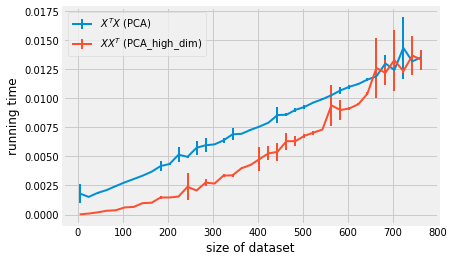

In [67]:
fig, ax = plt.subplots()
ax.set(xlabel='size of dataset', ylabel='running time')
bar = ax.errorbar(times_mm0[:, 0], times_mm0[:, 1], times_mm0[:, 2], label="$X^T X$ (PCA)", linewidth=2)
ax.errorbar(times_mm1[:, 0], times_mm1[:, 1], times_mm1[:, 2], label="$X X^T$ (PCA_high_dim)", linewidth=2)
ax.legend();

Alternatively, use the `time` magic command for benchmarking functions.

In [68]:
%time Xbar.T @ Xbar
%time Xbar @ Xbar.T
pass # Put this here so that our output does not show result of computing `Xbar @ Xbar.T`

CPU times: user 33.9 ms, sys: 11 ms, total: 44.8 ms
Wall time: 29.9 ms
CPU times: user 42.8 ms, sys: 4.23 ms, total: 47 ms
Wall time: 23.5 ms


Next we benchmark PCA, PCA_high_dim.

In [0]:
times0 = []
times1 = []

# iterate over datasets of different size
for datasetsize in np.arange(4, 784, step=100):
    XX = Xbar[:datasetsize]
    npc = 2
    mu, sigma = time(lambda : PCA(XX, npc), repeat=10)
    times0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : PCA_high_dim(XX, npc), repeat=10)
    times1.append((datasetsize, mu, sigma))
    
times0 = np.asarray(times0)
times1 = np.asarray(times1)

Let's plot the running time. Spend some time and think about what this plot means. We mentioned in lectures that PCA_high_dim are advantageous when
we have dataset size $N$ < data dimension $M$. Although our plot does not for the two running time does not intersect exactly at $N = M$, it does show the trend.

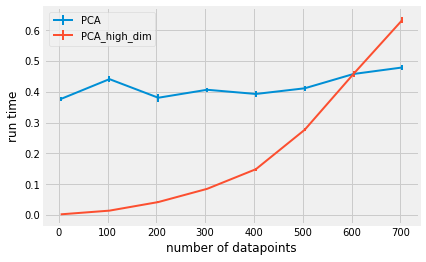

In [70]:
fig, ax = plt.subplots()
ax.set(xlabel='number of datapoints', ylabel='run time')
ax.errorbar(times0[:, 0], times0[:, 1], times0[:, 2], label="PCA", linewidth=2)
ax.errorbar(times1[:, 0], times1[:, 1], times1[:, 2], label="PCA_high_dim", linewidth=2)
ax.legend();

Again, with the magic command `time`.

In [71]:
%time PCA(Xbar, 2)
%time PCA_high_dim(Xbar, 2)
pass

CPU times: user 793 ms, sys: 236 ms, total: 1.03 s
Wall time: 522 ms
CPU times: user 2 s, sys: 559 ms, total: 2.56 s
Wall time: 1.29 s


## 3. PCA for dimension reduction

Sometimes, PCA is used for dimensionality reduction for the visualization of high dimensional data.

In [72]:
pca.n_components = 2
pca_data = pca.fit_transform(Xbar)
import seaborn as sn
# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)

shape of pca_reduced.shape =  (1000, 2)


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


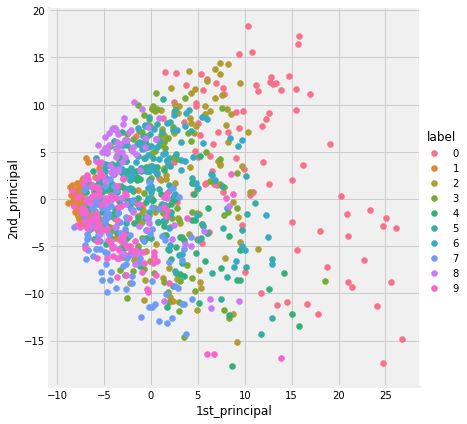

In [73]:
pca_data = np.vstack((pca_data.T, labels[:1000])).T

# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

There is a lot of overlapping among classes means PCA not very good for the high dimensional dataset. Very few classes can be separated but most of them are mixed. PCA is mainly used for dimensionality reduction, not for visualization. To visualize high dimension data, we mostly use T-SNE.
For more information about t-sne please refer to: https://medium.com/engineer-quant/t-sne-the-bits-that-no-one-learns-b5ce959ea1c2

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


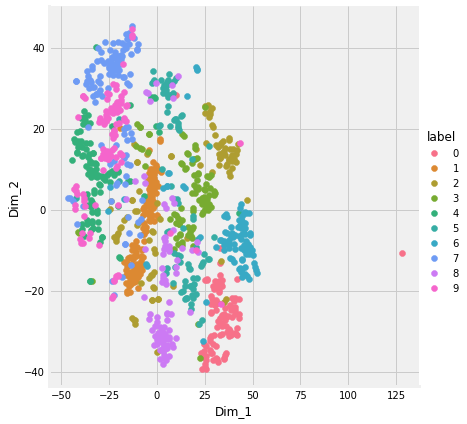

In [74]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(Xbar)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels[:1000])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

As shown in the figure, the distribution of MNIST data is clearly distinguished by their label.

## 4. Exercise
> Using the iris dataset which consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray, let's analyze the dataset using PCA. 
> You need to capture 2d-projected figures with **your own comments (short analysis)**.
> You can use the functions implemented above or use sklearn.


In [0]:
from sklearn.datasets import load_iris
data = load_iris()

First, We do the PCA on n_components of 2.
Then, we do dimensionality reduction on the dataset(which as 4 dimensions). Below figure is the 2d reconstructed data.

shape of pca_reduced.shape =  (150, 2)


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


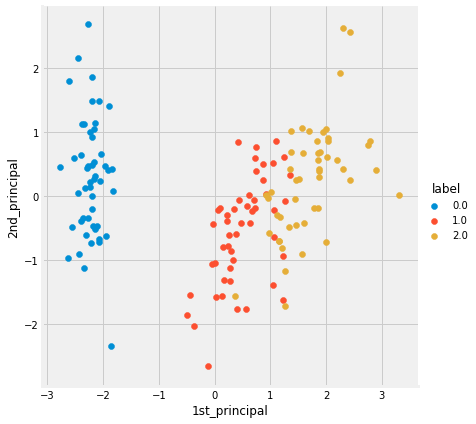

In [76]:
import seaborn as sn
pca.n_components = 2
Xbar, _, _= normalize(data['data'])
pca_data = pca.fit_transform(Xbar)
print("shape of pca_reduced.shape = ", pca_data.shape)
pca_data = np.vstack((pca_data.T, data['target'])).T
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

Now we will look at the PCA results and see 2d projected result figures of the PCA, by feature1/2, feature 3/4, and feature 2/3. We can see that feature 3/4 are very closely correlated.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


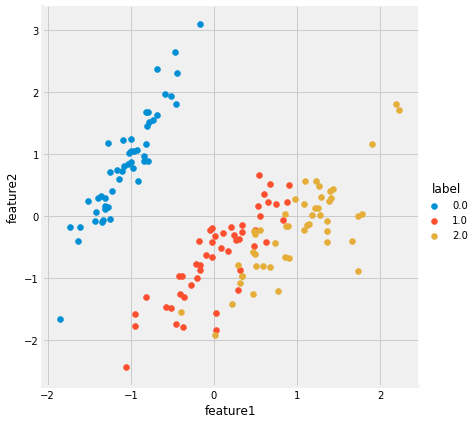

In [77]:
Xbar, _, _= normalize(data['data'])
pca_data = PCA(Xbar, 2)
pca_data = np.vstack((pca_data.T, data['target'])).T
pca_df = pd.DataFrame(data=pca_data, columns=("feature1", 'feature2', 'feature3', 'feature4', "label"))
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, "feature1", 'feature2').add_legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


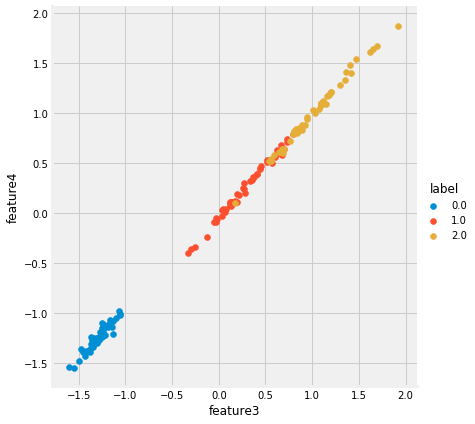

In [78]:
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, 'feature3', 'feature4').add_legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


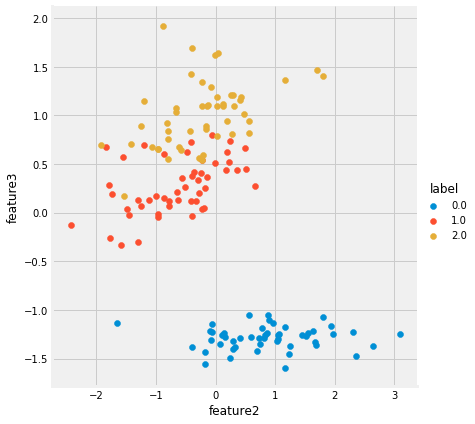

In [79]:
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, "feature2", 'feature3').add_legend()
plt.show()

Now we will visualize what PCA does on one axis. We project each of the dimensions into one column. The data distribution is as follows.



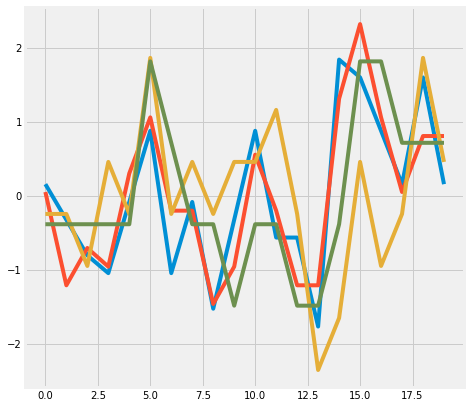

In [80]:
N = 20
X = data.data[:N, :4]
Xbar, mu, std = normalize(X)
plt.figure(figsize=(7,7))
plt.plot(Xbar)
plt.show()


Then, we see the PCA results with n_dimension of 2.

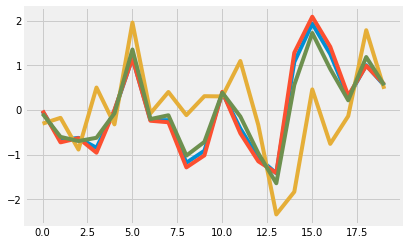

In [81]:
X2 = PCA(Xbar, 2)
plt.plot(X2)
plt.show()

Finally, we see the original data distribution (shown in the dotted line) and the PCA results (Projected into 2D and reconstructed again in the original dimension). We can see that variance is lowered, and PCA represents the data well with lower number of dimensions.(from 4 to 2)

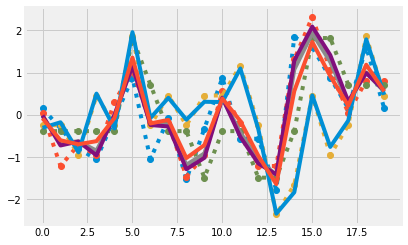

In [82]:
plt.plot(Xbar, 'o:')
plt.plot(X2)
plt.show()